In [1]:

import geatpy as ea
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from numpy import concatenate
import json
import numpy as np
import geatpy as ea
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras import optimizers
from sklearn.svm import SVR
from matplotlib import pyplot

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
wa = 1
wF = 0.8

EAs = ['soea_EGA_templet','soea_SEGA_templet']
#增强精英保留的遗传算法soea_SEGA_templet,'soea_SGA_templet','soea_steadyGA_templet','soea_SEGA_templet','soea_DE_best_1_bin_templet','soea_DE_best_1_L_templet','soea_DE_rand_1_bin_templet'

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
data_df = pd.read_csv('8area_DS1.csv')
@ea.Problem.single
def evalVars(Vars):
    features = data_df.columns[1:]
    features_name = []
    features_name.append(data_df.columns[0])
    for index in range(data_df.shape[1] - 1):
        if Vars[index] == 1:
            features_name.append(features[index])
    values = data_df[features_name]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[i for i in range(int(reframed.shape[1] / 2) + 1, reframed.shape[1])]], axis=1,
                  inplace=True)

    values = reframed.values
    n_train_hours = int(reframed.shape[0] * 0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    train_X_LSTM = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_LSTM = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()
    model.add(LSTM(70, input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Compile model
    learning_rate = 0.0003
    decay_rate = learning_rate / 100
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='mse', optimizer=sgd)
    # fit network
    history = model.fit(train_X_LSTM, train_y, epochs=60, batch_size=32, validation_data=(test_X_LSTM, test_y),
                        verbose=0, shuffle=False)
    yhat = model.predict(test_X_LSTM)
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    test_X_LSTM = test_X_LSTM.reshape((test_X_LSTM.shape[0], test_X_LSTM.shape[2]))
    inv_hat = concatenate((yhat, test_X_LSTM[:, 1:]), axis=1)
    inv_y = concatenate((test_y, test_X_LSTM[:, 1:]), axis=1)
    # inv_y = scaler.inverse_transform(inv_y)
    rmse = math.sqrt(mean_squared_error(yhat, test_y))
    # rmse = sqrt(mean_squared_error(inv_y, inv_hat))
    f = rmse * wa + ((len(features_name) - 1)/(len(data_df) - 1)) * wF
    return f

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   30   | 2.14995E-01 | 2.34709E-01 | 2.24530E-01 | 2.14995E-01 | 4.67418E-03 
 1 |   59   | 2.14083E-01 | 2.28667E-01 | 2.21094E-01 | 2.14083E-01 | 3.78876E-03 
 2 |   88   | 2.14083E-01 | 2.28717E-01 | 2.20620E-01 | 2.14083E-01 | 2.98452E-03 
 3 |  117   | 2.13591E-01 | 2.26542E-01 | 2.19072E-01 | 2.13591E-01 | 3.35103E-03 
 4 |  146   | 2.11390E-01 | 2.23558E-01 | 2.17904E-01 | 2.11390E-01 | 3.01806E-03 
 5 |  175   | 2.08223E-01 | 2.22125E-01 | 2.16488E-01 | 2.08223E-01 | 2.93251E-03 
 6 |  204   | 2.08223E-01 | 2.18676E-01 | 2.15213E-01 | 2.08223E-01 | 2.50384E-03 
 7 |  233   | 2.08223E-01 | 2.19928E-01 | 2.14537E-01 | 2.08223E-01 | 3.09682E-03 
 8 |  262   | 2.08223E-01 | 2.20808E-01 | 2.13948E-01 | 2.08223E-01 | 2.51790E-03 
 9 |  291   | 2.08223E-01 | 2.20701E-01 | 2.13639E-01 | 2.08223E-01 | 2.40004E-03 
 10|

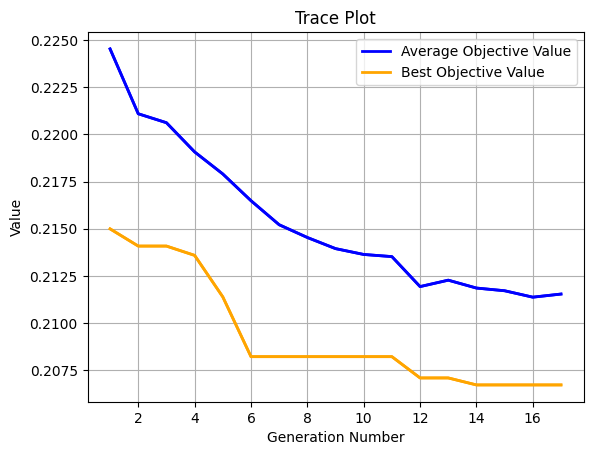

Execution time: 1355.6829688549042 s
Evaluation number: 494
The best objective value is: 0.20672556719347993
The best variables are: 
1	1	0	0	0	1	0	0	1	0	0	0	1	0	0	1	0	0	1	1	0	1	0	0	0	0	0	0	0	0	0	1	0	0	0	1	0	1	1	0	1	0	0	0	0	0	0	1	0	0	1	0	0	0	1	0	0	1	0	1	0	0	1	0	0	0	0	0	1	0	0	0	1	1	0	0	1	0	1	0	0	1	0	0	1	0	0	0	1	1	0	0	1	0	1	
gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   30   | 2.13674E-01 | 2.32656E-01 | 2.23965E-01 | 2.13674E-01 | 4.43198E-03 
 1 |   60   | 2.11437E-01 | 2.23131E-01 | 2.19486E-01 | 2.11437E-01 | 2.91102E-03 
 2 |   90   | 2.08805E-01 | 2.19307E-01 | 2.16372E-01 | 2.08805E-01 | 2.70932E-03 
 3 |  120   | 2.07042E-01 | 2.16661E-01 | 2.14183E-01 | 2.07042E-01 | 2.50434E-03 
 4 |  150   | 2.07042E-01 | 2.14813E-01 | 2.12204E-01 | 2.07042E-01 | 2.08259E-03 
 5 |  180   | 2.05953E-01 | 2.12005E-01 | 2.09784E-01 | 2.05953E-01 | 1.80103E-03 
 6 |  210  

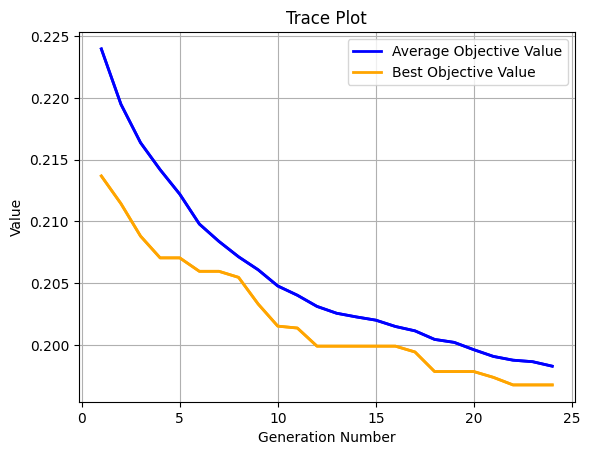

Execution time: 2203.477699995041 s
Evaluation number: 720
The best objective value is: 0.1967519926714836
The best variables are: 
0	0	1	0	0	1	1	0	0	0	0	1	0	1	0	0	1	0	0	0	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	1	0	0	1	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	1	1	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	1	0	0	0	0	0	1	0	0	1	0	0	


In [5]:
for EA_NAME in EAs:
    #定义问题
    problem = ea.Problem(name = EA_NAME,
                 M = 1,
                 maxormins = [1],
                 Dim = data_df.shape[1]- 1,
                 varTypes = [1 for i in range(data_df.shape[1] - 1)],
                 lb = [0 for i in range(data_df.shape[1] - 1)],
                 ub = [1 for i in range(data_df.shape[1] - 1)],
                 evalVars = evalVars)
    
    algorithm = getattr(ea, EA_NAME)(problem,
                                ea.Population(Encoding = 'RI',NIND = 30),
                                MAXGEN = 50,
                                logTras = 1,
                                trappedValue = 1e-6,
                                maxTrappedCount = 10)
    res = ea.optimize(algorithm, seed=1, verbose=True, drawing=1, outputMsg=True, drawLog=False, saveFlag=True, dirName=EA_NAME)